<h1>Analysis Including Only Top 75% Respondents</h1>
<p>
<div class="explanation">
This analysis includes all slider and likert questions. But only
'serious' respondents are included. Seriousness was measured by
how many zeroes a respondent left. Serious respondents left at most
as many zeroes as 75% of all respondents. This procedure left 118 
respondents.
<p>
Three alternatives are presented for combining questions:
<ul>
<li>Pairwise correlations are computed from the answers to all questions.
These 6670 correlations are sorted, highest first. The resulting list can be
considered top to bottom. The lower a question pair is on the list, the
less similar the two questions are in the insights they capture.
</li>
<li>A dendrogram approach that uses the <a href="https://en.wikipedia.org/wiki/Ward%27s_method">
<i>Ward</i></a> algorithm for creating clusters
of 'related' questions, based on 'similarity' between the answers to those questions.
Similarity is measured by how similar the variances in the answers to the two questions are.</li>
<li>A dendrogram approach using the <a href="https://en.wikipedia.org/wiki/UPGMA"><i>UPGMA</i></a>
a.k.a. <i>averaging</i> algorithm.</li> Clusters are formed by minimizing the sum of 
distances between all pairs in one cluster and all pairs in neighboring clusters.
</ul>
The first method is the most direct and understandable.
</div>

In [94]:
     from IPython.core.display import HTML, display
     HTML("""
         <style>
           h1        {text-align : center}
           .subtitle {text-align : center}
           .explanation {font-size : large; 
                         line-height : 125%;
                        }
           .container { width:100% !important; }
           .highlight { background-color : yellow;}
           hr         { height : 3px;
                        background: black
                      }
         </style>
         """)


In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [93]:
%matplotlib inline

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy import cluster
import numpy as np
import pandas as pd
import seaborn as sns
import os
from itertools import product
#import survey_utils

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [4]:
dataPath = os.path.join(os.getenv("HOME"), 
                        #'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/slidersLikertByItem.csv'
                        'Project/WomenIndustrySurveyHolzblatt/Data/DataForClustering/likertSlidersByRespondentUnfolded.csv'
                       )

data = pd.read_csv(dataPath, sep=',')
# Make the question column the index, so that
# all operations on the dataframe only address
# the numeric scores:
data = data.set_index('question')
# Replace 0s with their column's median.
#data = utils.replaceZerosDataFrame(data, direction='row')


In [5]:
#data[data[data.columns] == 0]
#data['s0'].value_counts().sort_values()
# Number of zeroes in a column:
#type(data[data.columns[0]]) #--> series
#data['s0'].value_counts()[0]
#data[data.columns].values.transpose()
#data[data.columns].value_counts()[0]
participants_as_rows = data[data.columns].transpose()
#participants_as_rows.describe()
#participants_as_rows.loc[participants_as_rows == 0]

In [6]:
# Remove the spurious: Men|NoFormerCollab12, Men|NoFormerCollab37, Men|NoFormerCollab62
try:
    data.drop(['Men|NoFormerCollab12', 'Men|NoFormerCollab37', 'Men|NoFormerCollab62', 'Men|NoFormerCollab87'], inplace=True)
except ValueError:
    # Already ran this cell, so the entries are gone:
    pass


<div class="explanation">Find respondents who answered 'most' questions. Method:
Count the number of zeroes of every respondent. Sort
those numbers in increasing order. Accept the first
75% of the respondents.
</div>

In [7]:
num_zeroes = participants_as_rows.apply(pd.Series.value_counts, axis=1)[0]
num_zeroes_sorted = num_zeroes.sort_values()
num_records = len(num_zeroes_sorted)
seventy_five_perc_cutoff = np.round(np.round(75*num_records/100)) # 163


In [8]:
#print('Median number of zeroes: %s' % num_zeroes.median())
#print('Mean number of zeroes: %s' % num_zeroes.mean())
#print('75th percentile zeroes: %s' % num_zeroes.quantile(0.75))


In [9]:

#num_zeroes_sorted.iloc[seventy_five_perc_cutoff] # 102
#num_zeroes_sorted.iloc[99:104]
#"num_zeroes_sorted

In [10]:
# Get list of ids for participants who were 
# with 75th percentile of non-zero entries.
# I.e. drop participants with the top 25% number
# of zero answers:
serious_respondent_ids = num_zeroes_sorted.iloc[0:seventy_five_perc_cutoff].index
serious_respondents = data[serious_respondent_ids]
#len(serious_respondents) # 119
#serious_respondents.head(4)

In [11]:
html_str = 'Number of serious respondents: <span class="highlight">: %s' % len(serious_respondents)
HTML(html_str)

<h2>Correlation Matrix Method for Finding Similar Questions</h2>

In [12]:
corr_matrix = serious_respondents.transpose().corr()
#corr_matrix

In [13]:
# Zero out the upper triangle of the (symmetric) matrix:
corr_matrix_ltriag = np.tril(corr_matrix)
#corr_matrix_ltriag

In [14]:
# Get rid of the lower-left triangle of the correlation matrix:

#array([[ True, False, False],
#       [ True,  True, False],
#       [ True,  True,  True]], dtype=bool)

corr_matrix_tri_lower_mask = np.tril(np.ones(corr_matrix.shape).astype(np.bool))
#corr_matrix_tri_lower

# This mask to turn upper triangle into NaNs:
corr_matrix_tri_lower = corr_matrix.where(corr_matrix_tri_lower_mask)


<h3>Flatten matrix into a one-column DataFrame, then sort by decreasing correlation:</h3>

In [27]:
row_name_series = pd.Series(corr_matrix_tri_lower.index.values)
col_name_series = pd.Series(corr_matrix_tri_lower.columns.values)
# Get: Series([(SurveyItem1, SurveyItem1),
#              (SurveyItem1, SurveyItem2),
#              (SurveyItem1, SurveyItem3),
#              (SurveyItem2, SurveyItem1),
#              (SurveyItem2, SurveyItem2),
#              (SurveyItem2, SurveyItem3),
#                     ...
#            ])
all_cell_names  = pd.Series(list(product(row_name_series, col_name_series)))
#all_cell_names

# Flatten the correlation matrix into a 1-column DF:
named_correlations = pd.DataFrame(corr_matrix_tri_lower.values.flatten(), index=all_cell_names, columns=['Correlations'])

# Remove the diagonal 1s entries: 

# Currently the question-pairs are the index. Turn them into a 
# second column named 'Questions':
#                   	Questions                       	Correlations
#    0 	(PersonalExperience|ILackConfidence, PersonalE... 	1.000000
#    1 	(PersonalExperience|ILackConfidence, WorkLife|... 	0.620947

named_correlations = named_correlations.reset_index().rename(columns={'index' : 'Questions'})
named_correlations = named_correlations.where(named_correlations.Questions.apply(lambda x: x[0] != x[1])).dropna()
named_correlations

# Sort by descending correlation:
# 	Questions 	Correlations
#9404 	(Team|NotPartOfGrp, Manager|HesitateToTakeChal... 	1.000000
#9755 	(Manager|HesitateToTakeChallenges, Team|NotPar... 	1.000000
#     ...
#2840 	(Promoted|UnsureWhatToDo, Promoted|DontWantClimb) 	0.995508
#968 	(Promoted|DontWantClimb, Promoted|UnsureWhatToDo) 	0.995508
#5330 	(Balance|ManagerSendsHome, Balance|CultureSupp... 	0.994896
#2405 	(Balance|CultureSupportive, Balance|ManagerSen... 	0.994896
#     ...
         
named_correlations.sort_values(by='Correlations', ascending=False, inplace=True)
#named_correlations
#len(named_correlations)

6670

In [16]:
cm = sns.light_palette("green", as_cmap=True)

styled_named_correlations = named_correlations.style.background_gradient(cmap=cm)
styled_named_correlations

<h2>Dendrogram Method Using Ward for Clustering</h2>
<div class="explanation">This method finds cluster members by grouping those questions that had very similar variances.
</div>

(Note: more readable question layout further down)


In [35]:
# Find the best algorithm for dendrogram clustering. Supposedly
# the algorithm with the largest Cophenet correlation coefficient
# tends to be best:

# Cophenet correlation coefficient measures 
# how faithfully a dendrogram preserves pairwise
# distance between the original data points, use
# the algo that yields the highest coefficient:

max_c = 0
max_algo = ''
max_cluster_info = None
algo_results = {}
for algo in ['ward', 'centroid', 'weighted', 'average', 'complete', 'single']:
    cluster_info = linkage(serious_respondents, algo)
    (c, coph_dists) = cophenet(cluster_info, pdist(serious_respondents))
    if c > max_c:
        max_c = c
        max_algo = algo
        max_cluster_info = cluster_info
    algo_results[algo] = {'cophenet_coeff' : c,
                          'cluster_info' : cluster_info
                          }
print("Winning Cocophenet correlation coefficient is the '%s' algorithm: %s" % (max_algo, max_c))
# cluster_info = max_cluster_info
# algo = max_algo
print("... but using Ward (c= %s)" % algo_results['ward']['cophenet_coeff'])

algo = 'ward'
cluster_info = algo_results[algo]['cluster_info']


Winning Cocophenet correlation coefficient is the 'average' algorithm: 0.864747391781
... but using Ward (c= 0.747673926917)


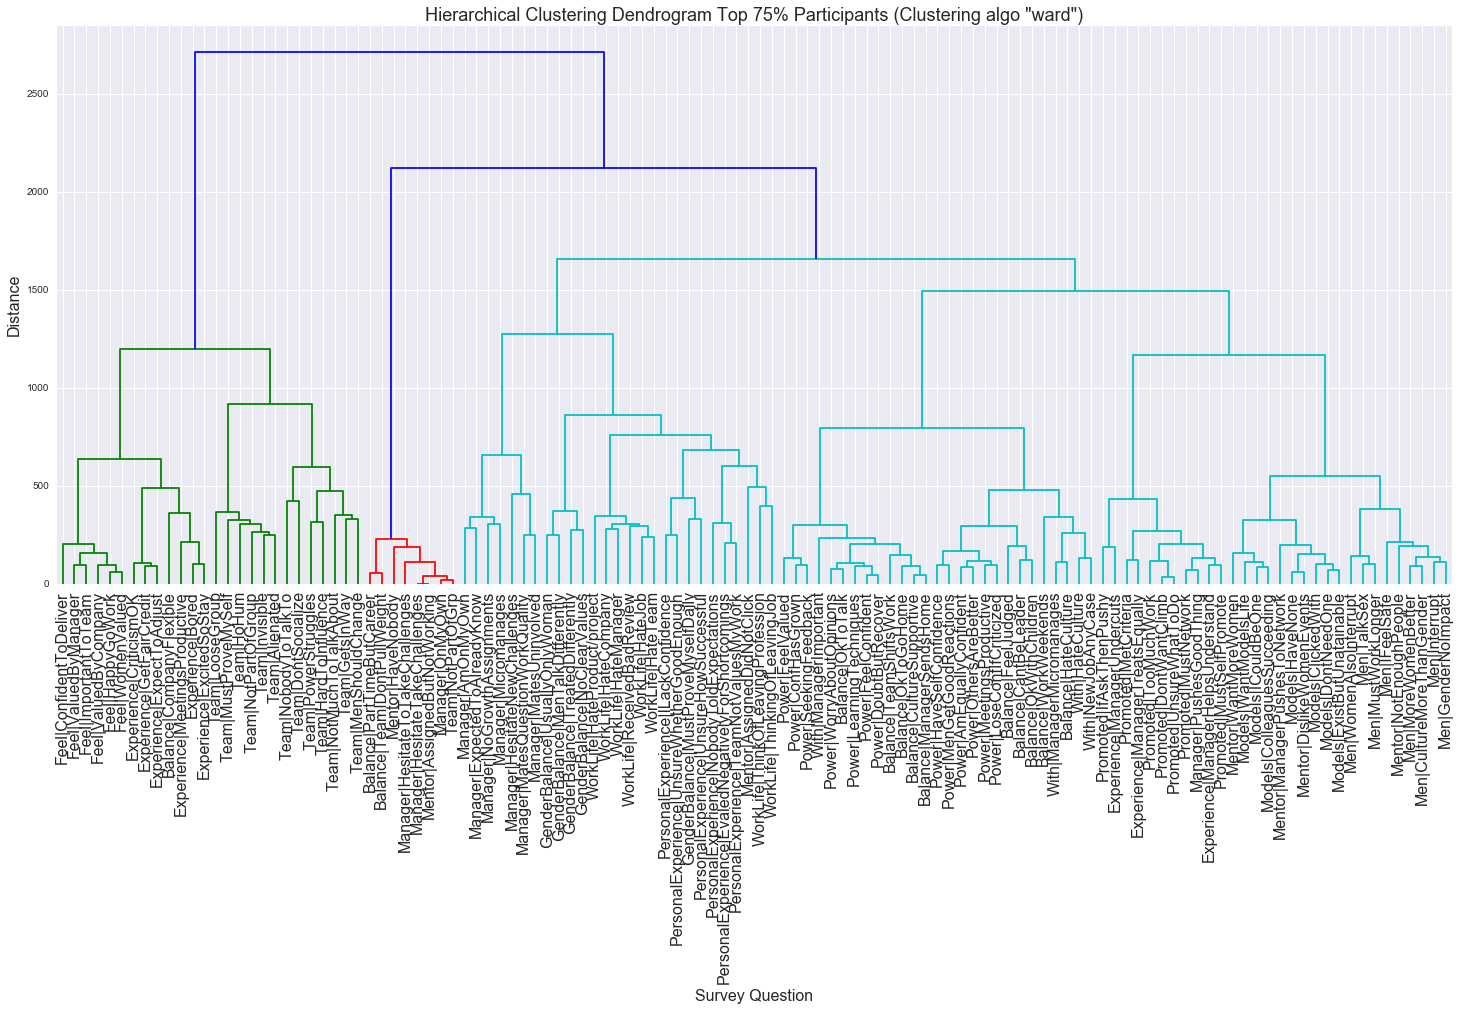

In [36]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top 75%% Participants (Clustering algo "%s")' % algo
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=data.index,  # question names
)
plt.show()



<div class="explanation">Make groups more readable:</div>

In [37]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )
ward_clusters = clusters.copy()
def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''
    
clusters.style.applymap(cluster_table_styler)


<h2>Alternative Dendrogram: using highest-cophenet-coefficient algorithm ('average'):</h2>
<div class="explanation">
The <i>average</i> clustering method minimizes the average distance between any two elements of neighboring clusters.
The method is also known as UPGMA <b>U</b>nweighted <b>P</b>air <b>G</b>roup <b>M</b>ethod with <b>A</b>rithmetic <b>M</b>ean.
</div>

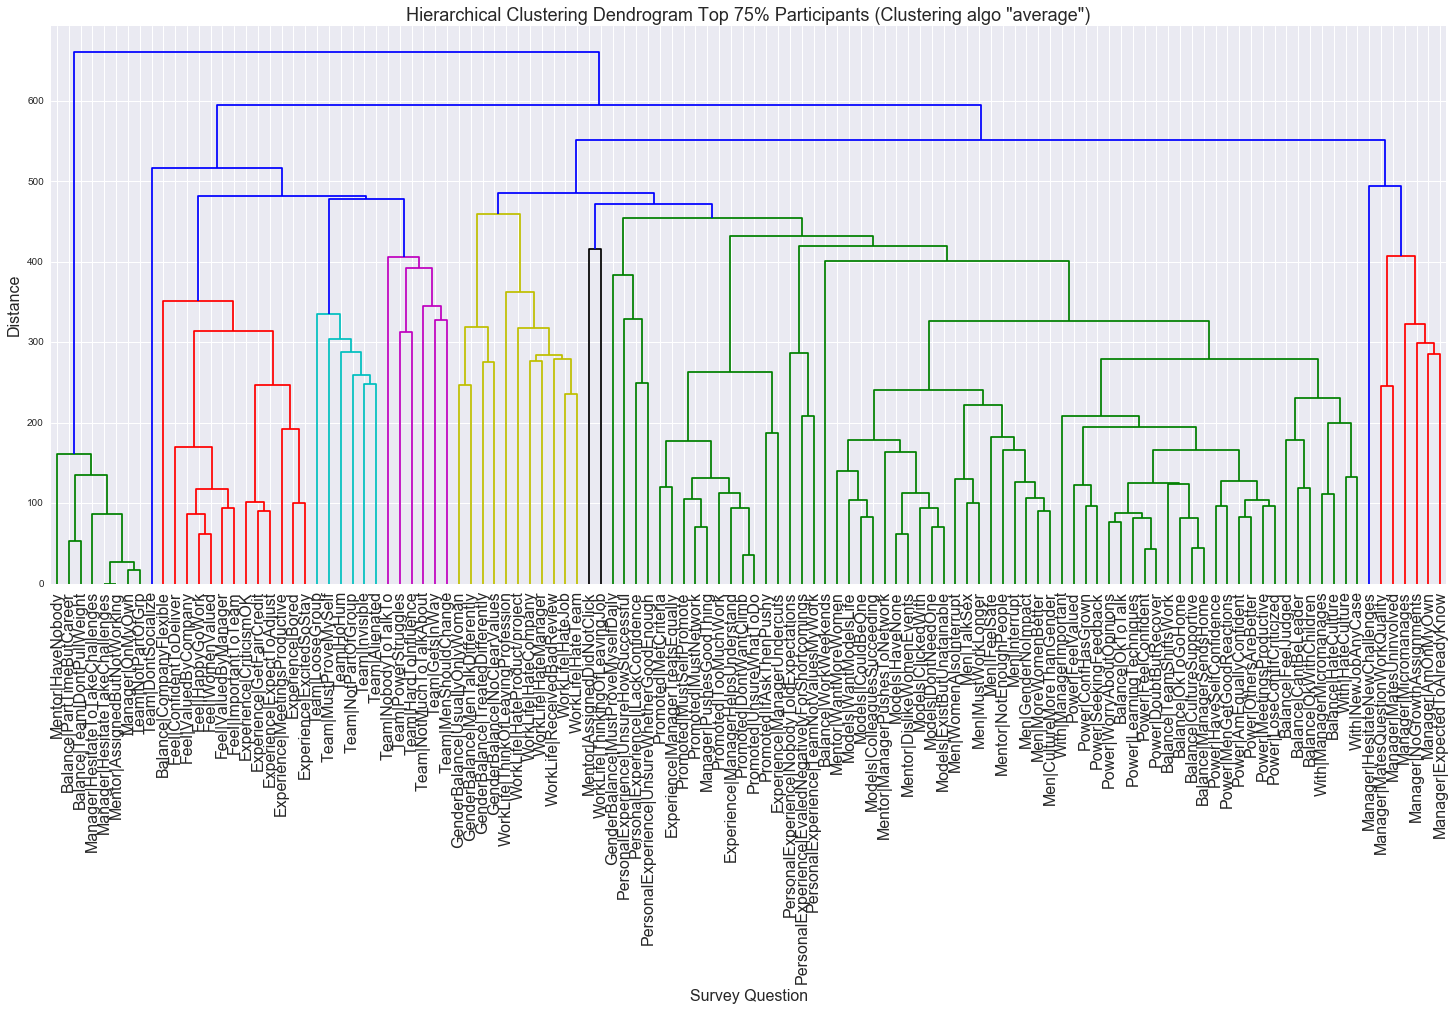

In [21]:
algo = max_algo

# calculate full dendrogram
plt.figure(figsize=(25, 10))
title = 'Hierarchical Clustering Dendrogram Top 75%% Participants (Clustering algo "%s")' % algo
plt.title(title, fontsize=18)
plt.xlabel('Survey Question', fontsize=16)
plt.ylabel('Distance', fontsize=16)
dendrogram_data = dendrogram(
        algo_results[algo]['cluster_info'],
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
        labels=data.index,  # question names
)
plt.show()



<div class="explanation">
Make groups easier to read:
</div>

In [22]:
# Build a DataFrame that combines question, distance, and color.
# Then change the names of the one-letter colors to more readable
# expanded form:
clusters = zip(dendrogram_data['ivl'], dendrogram_data['leaves'], dendrogram_data['color_list'])
clusters = pd.DataFrame(clusters, columns=['Question', 'Distance', 'Color'])
clusters['Color'].replace(['g','r','b','c','m','y','k'], 
                          ['green','red','blue','cyan','magenta','yellow','black'],
                          inplace=True
                          )

def cluster_table_styler(val):
    if val == 'green':
        return("background-color : green")
    elif val == 'red':
        return("background-color : red")
    elif val == 'blue':
        return("background-color : blue")
    elif val == 'cyan':
        return("background-color : cyan")
    elif val == 'magenta':
        return("background-color : magenta")
    elif val == 'yellow':
        return("background-color : yellow")
    elif val == 'black':
        return("background-color : black")
    else:
        return ''
    
clusters.style.applymap(cluster_table_styler)

<hr>

Reshape <i>serious_respondents</i> to have rows be 'observations' (i.e. all answers by one respondent).
Have the columns be the question answers: the 'features':

In [122]:
# Make a copy of serious_respondents to work with:
some_respondents = serious_respondents.copy().ix[ward_questions].reset_index().rename(columns={'index' : 'Question'})
some_respondents = some_respondents.set_index('question').transpose()
some_respondents = some_respondents.astype(np.float)
#some_respondents.head(3)

question  Feel|ConfidentToDeliver  Feel|ValuedByManager  Feel|ImportantToTeam  \
s100                         62.0                  62.0                  62.0   
s98                          62.0                  62.0                  62.0   
s97                          62.0                  62.0                  62.0   

question  Feel|ValuedByCompany  Feel|HappyGoWork  Feel|WomenValued  \
s100                      62.0              62.0              62.0   
s98                       62.0              62.0              62.0   
s97                       62.0              62.0              62.0   

question  Experience|CriticismOK  Experience|GetFairCredit  \
s100                        62.0                      62.0   
s98                         62.0                      62.0   
s97                         62.0                      62.0   

question  Experience|ExpectToAdjust  Balance|CompanyFlexible  \
s100                           62.0                     62.0   
s98                            62.0                     62.0   
s97                            62.0                     62.0   

question               ...                Team|PowerStruggles  \
s100                   ...                               41.0   
s98                    ...                               59.0   
s97                    ...                              100.0   

question  Team|HardToInfluence  Team|NotMuchToTalkAbout  Team|GetsInWay  \
s100                      59.0                     65.0            47.0   
s98                       35.0                     71.0            71.0   
s97                       71.0                     82.0           100.0   

question  Team|MenShouldChange  Balance|PartTimeButCareer  \
s100                      47.0                       37.0   
s98                       82.0                       12.0   
s97                       88.0                        0.0   

question  Balance|TeamIDontPullWeight  Mentor|HaveNobody  \
s100                             37.0                0.0   
s98                              12.0                0.0   
s97                              12.0                0.0   

question  Manager|HesitateToTakeChallenges  Manager|HesitateTakeChallenges  
s100                                   0.0                             0.0  
s98                                    0.0                             0.0  
s97                                    0.0                             0.0  

[3 rows x 31 columns]

Compute clusters for k=1 to k=10. Plot the resulting 
overall distortion for each k. Then pick a k where
the curve has an 'elbow'. Our case, 4 clusters is an option:

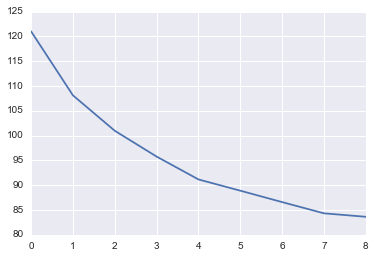

In [125]:
# Get clustering for k=1 to k=10 to see where distortion levels out:
initial = [cluster.vq.kmeans(some_respondents, k) for k in range(1,10)]
#initial
plt.plot([distortion for (centroids, distortion) in initial])

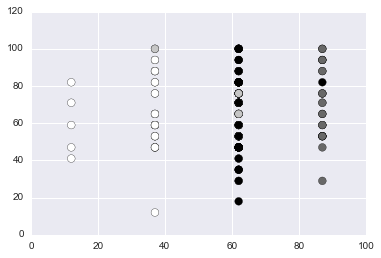

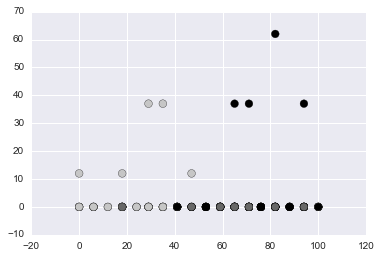

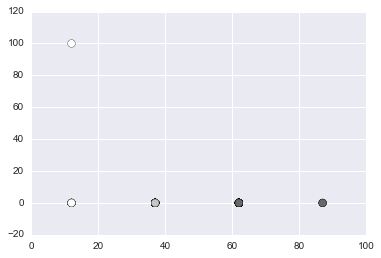

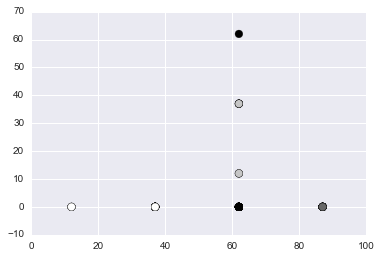

In [148]:
# Pick four clusters:
(centroids, distortion) = initial[3]

# Assign each observation to one cluster:
(centroid_assignments, distortions) = cluster.vq.vq(some_respondents, centroids)

green_ward_questions = ward_clusters[ward_clusters.Color == 'green']
red_ward_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_ward_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_ward_questions = ward_clusters[ward_clusters.Color == 'blue']

#green_questions.sample().Question
#print(some_respondents[green_questions.sample().Question])
#green_questions

# NEXT: DROP the zeroes**********
for i in range(4):
    green_question = green_ward_questions.sample().Question
    red_question   = red_ward_questions.sample().Question
    plt.scatter(some_respondents[green_question], some_respondents[red_question],
            c=centroid_assignments,
            s=60)
    plt.show()


<hr>

In [130]:
ward_clusters.head(3)
ward_clusters[ward_clusters.Color == 'green']
green_questions = ward_clusters[ward_clusters.Color == 'green']
red_questions = ward_clusters[ward_clusters.Color == 'red']
cyan_questions = ward_clusters[ward_clusters.Color == 'cyan']
blue_questions = ward_clusters[ward_clusters.Color == 'blue']

In [90]:
ward_questions = ward_clusters['Question'].iloc[:31]
len(ward_questions)
#plt.plot(data[ward_questions])
some_respondents = serious_respondents.copy().ix[ward_questions].reset_index().rename(columns={'index' : 'Question'})
some_respondents = some_respondents.rename(columns={'question' : 'Question'})
thin_ward_clusters = ward_clusters[['Question', 'Color']].set_index('Question')
thin_some_respondents = some_respondents.set_index('Question')
thin_some_respondents = thin_some_respondents.join(thin_ward_clusters, how='inner')
#thin_some_respondents
#thin_ward_clusters


In [92]:
import os
thin_some_respondents.reset_index().to_csv(os.path.join(os.getenv('HOME'), 'tmp/some_respondents.csv'))
thin_some_respondents


s100  s98  s97  s79  s48  s85  s57  s58  \
Question                                                                    
Feel|ConfidentToDeliver             62   62   62   62   62   62   62   62   
Feel|ValuedByManager                62   62   62   62   62   62   62   62   
Feel|ImportantToTeam                62   62   62   62   62   62   62   62   
Feel|ValuedByCompany                62   62   62   62   37   62   62   62   
Feel|HappyGoWork                    62   62   62   62   37   62   62   62   
Feel|WomenValued                    62   62   62   62   37   62   37   37   
Experience|CriticismOK              62   62   62   62   62   62   62   62   
Experience|GetFairCredit            62   62   62   62   62   62   62   62   
Experience|ExpectToAdjust           62   62   62   62   62   62   62   62   
Balance|CompanyFlexible             62   62   62   37   12   37   12   12   
Experience|MeetingsProductive       62   62   62   62   37   62   37   37   
Experience|Bored                    62   37   37   37   37   37   37   37   
Experience|ExcitedSoStay            37   37   37   37   37   37   37   37   
Team|LooseGroup                     82   24   29   24   41   47   94   18   
Team|MustProveMySelf                88   29    6   82   12   41   94   65   
Team|HoHum                         100   29   18   71   53   88  100   65   
Team|NotPartOfGroup                 94    0   18   65   41   82   94   65   
Team|Invisible                      82   29   12   59   18   29  100   65   
Team|Alienated                      76   12   12   59   53   71   94   71   
Team|NobodyToTalkTo                 65   65   76   41   59   59   47   59   
Team|DontSocialize                  76   71   59   41   76   12   47   53   
Team|PowerStruggles                 41   59  100   65   94   29   88   65   
Team|HardToInfluence                59   35   71   41   65   65   41   35   
Team|NotMuchToTalkAbout             65   71   82   71   65   76   71   65   
Team|GetsInWay                      47   71  100   47   88   88   59   59   
Team|MenShouldChange                47   82   88   47   47   71   65   53   
Balance|PartTimeButCareer           37   12    0    0    0    0    0    0   
Balance|TeamIDontPullWeight         37   12   12    0    0    0    0    0   
Mentor|HaveNobody                    0    0    0    0    0    0    0    0   
Manager|HesitateToTakeChallenges     0    0    0    0    0    0    0    0   
Manager|HesitateTakeChallenges       0    0    0    0    0    0    0    0   

                                  s60  s63  ...    s165  s164  s162  s159  \
Question                                    ...                             
Feel|ConfidentToDeliver            62   62  ...      87    87    87    87   
Feel|ValuedByManager               62   62  ...      87    87    87    87   
Feel|ImportantToTeam               62   62  ...      62    62    62    62   
Feel|ValuedByCompany               62   62  ...      87    62    62    62   
Feel|HappyGoWork                   62   62  ...      62    62    62    62   
Feel|WomenValued                   62   62  ...      62    62    62    62   
Experience|CriticismOK             62   62  ...       0     0     0     0   
Experience|GetFairCredit           62   62  ...       0     0     0     0   
Experience|ExpectToAdjust          62   62  ...       0     0     0     0   
Balance|CompanyFlexible            12   37  ...      62    62    62    62   
Experience|MeetingsProductive      37   37  ...       0     0     0     0   
Experience|Bored                   37   37  ...       0     0     0     0   
Experience|ExcitedSoStay           37   37  ...       0     0     0     0   
Team|LooseGroup                    35   76  ...      71    41    71    65   
Team|MustProveMySelf               59   82  ...      82    41    76    65   
Team|HoHum                         53   76  ...      53    41    88    88   
Team|NotPartOfGroup                35   53  ...      65    71    59    71   
Team|Invisible               